In [1]:
import numpy as np
import awkward as ak

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors

from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
data = pickle.load( open( "data_bce.pkl", "rb" ) )
X_train, y_train, X_val, y_val, X_test, y_test = data

/home/lvaughan/VirtualEnvs/torch/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


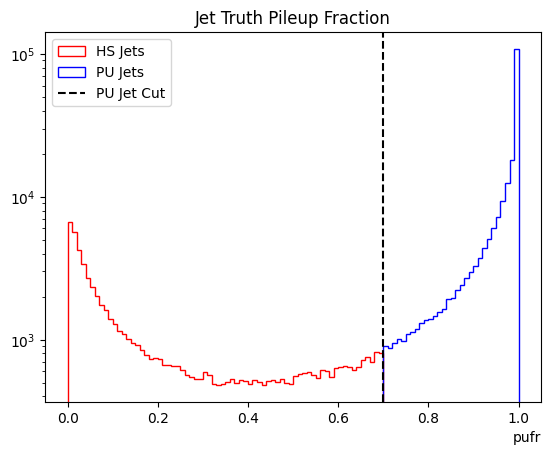

In [3]:
threshold = 0.7

y_train = ak.Array(y_train)

sig = (ak.Array(y_train) < threshold)
bkg = ~sig

plt.title("Jet Truth Pileup Fraction")
plt.hist(ak.ravel(y_train[sig]),histtype='step',bins=int(100*threshold),label='HS Jets',color='r')
plt.hist(ak.ravel(y_train[bkg]),histtype='step',bins=int(100*(1-threshold)),label='PU Jets',color='b')

plt.axvline(x = threshold, color = 'k', label = 'PU Jet Cut',linestyle='dashed')
plt.xlabel("pufr",loc='right')
plt.legend()
plt.yscale('log')
plt.show()

In [4]:
labels = [y_train,y_val,y_test]
binary_labels = []
for label in labels:
    label_list = []
    binary = ak.values_astype((ak.Array(label) < threshold), int)
    num_events = len(binary)
    for event in range(num_events):
        label_list.append(torch.Tensor(binary[event]))
    binary_labels.append(label_list)
y_train,y_val,y_test = binary_labels

In [5]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Encoder, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim,num_heads=num_heads,batch_first=True, dropout=0.25)
        self.out = nn.Linear(embed_dim,embed_dim)
    def forward(self, Query, Key, Value):
        context, weights = self.attention(Query, Key, Value)
        latent = Query + context
        tmp = F.gelu(self.out(latent))
        latent = latent + tmp
        return latent, weights

class AttnModel(nn.Module):
    def __init__(self, num_jet_feats, num_trk_feats, embed_dim, num_heads, out_classes):
        super(AttnModel, self).__init__()        
        
        self.jet_initializer = nn.Linear(num_jet_feats, embed_dim)
        self.trk_initializer = nn.Linear(num_trk_feats, embed_dim)
        self.all_trk_initializer = nn.Linear(num_trk_feats, embed_dim)
        
        self.trk_postprocess = nn.Linear(embed_dim*2, embed_dim)

        self.trk_encoder1 = Encoder(embed_dim, num_heads)
        self.trk_encoder2 = Encoder(embed_dim, num_heads)
        self.trk_encoder3 = Encoder(embed_dim, num_heads)

        self.all_trk_encoder1 = Encoder(embed_dim, num_heads)
        self.all_trk_encoder2 = Encoder(embed_dim, num_heads)
        self.all_trk_encoder3 = Encoder(embed_dim, num_heads)

        self.jet_encoder1 = Encoder(embed_dim, num_heads)
        self.jet_encoder2 = Encoder(embed_dim, num_heads)
        self.jet_encoder3 = Encoder(embed_dim, num_heads)

        self.classifier = nn.Linear(embed_dim,out_classes)
        
    def forward(self, jet_feats, trk_feats, all_trk_feats, return_weights=False):
        # Preprocess Feats
        jet_init = F.gelu(self.jet_initializer(jet_feats))
        trk_init = F.gelu(self.trk_initializer(trk_feats))
        all_trk_init = F.gelu(self.all_trk_initializer(all_trk_feats))
        
        # Track Encoder
        trk_embedding, trk_weights = self.trk_encoder1(trk_init,trk_init,trk_init)
        trk_embedding, trk_weights = self.trk_encoder2(trk_embedding,trk_embedding,trk_embedding)
        trk_embedding, trk_weights = self.trk_encoder3(trk_embedding,trk_embedding,trk_embedding)
        trk_aggregated = trk_embedding.sum(dim=1)
        jet_embedding = torch.cat((jet_init, trk_aggregated),1)
        jet_embedding = F.gelu(self.trk_postprocess(jet_embedding))
        
        # Cross Attention
        jet_embedding, cross_weights = self.all_trk_encoder1(jet_embedding,all_trk_init,all_trk_init)
        jet_embedding, cross_weights = self.all_trk_encoder2(jet_embedding,all_trk_init,all_trk_init)
        jet_embedding, cross_weights = self.all_trk_encoder3(jet_embedding,all_trk_init,all_trk_init)

        # Jet Attention
        jet_embedding, jet_weights = self.jet_encoder1(jet_embedding,jet_embedding,jet_embedding)
        jet_embedding, jet_weights = self.jet_encoder2(jet_embedding,jet_embedding,jet_embedding)
        jet_embedding, jet_weights = self.jet_encoder3(jet_embedding,jet_embedding,jet_embedding)

        # Classify
        output = F.sigmoid(self.classifier(jet_embedding))
        
        if return_weights:
            return output, jet_weights, cross_weights, trk_weights
        return output

In [6]:
# Get Instance of the model
num_jet_feats = 6
num_trk_feats = 6
embed_dim = 32
num_heads = 8
out_classes = 1
model = AttnModel(num_jet_feats,num_trk_feats,embed_dim,num_heads,out_classes)
print(model)
print()

# Pass some data to the model and print outputs
Event_no = 0
Jets    = 0
Trk_Jet = 1
Trks     = 2
output = model(X_train[Event_no][Jets],X_train[Event_no][Trk_Jet],X_train[Event_no][Trks])
print(output.shape)

# Evaluate the loss
loss_fn = nn.BCELoss()
print(loss_fn(output,y_train[Event_no]))

AttnModel(
  (jet_initializer): Linear(in_features=6, out_features=32, bias=True)
  (trk_initializer): Linear(in_features=6, out_features=32, bias=True)
  (all_trk_initializer): Linear(in_features=6, out_features=32, bias=True)
  (trk_postprocess): Linear(in_features=64, out_features=32, bias=True)
  (trk_encoder1): Encoder(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (out): Linear(in_features=32, out_features=32, bias=True)
  )
  (trk_encoder2): Encoder(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (out): Linear(in_features=32, out_features=32, bias=True)
  )
  (trk_encoder3): Encoder(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (out): Linear(in_features=32, out_features=32, bias=True)
  )
  (all_trk

In [7]:
def train(model, X_train, y_train, X_val, y_val, epochs=40):
    
    combined_history = []
    
    num_train = len(X_train)
    num_val = len(X_val)
    
    for e in range(epochs):
        model.train()
        cumulative_loss_train = 0

        for i in range(num_train):
            optimizer.zero_grad()
            
            output = model(X_train[i][0].to(device), X_train[i][1].to(device), X_train[i][2].to(device))
            
            loss=loss_fn(output, y_train[i].to(device))
            
            loss.backward()
            optimizer.step()
            
            cumulative_loss_train+=loss.detach().cpu().numpy().mean()
            
        cumulative_loss_train = cumulative_loss_train / num_train
        
        model.eval()
        cumulative_loss_val = 0
        for i in range(num_val):
            output = model(X_val[i][0].to(device), X_val[i][1].to(device), X_val[i][2].to(device))
            loss=loss_fn(output, y_val[i].to(device))
            
            cumulative_loss_val+=loss.detach().cpu().numpy().mean()
            
        cumulative_loss_val = cumulative_loss_val / num_val

        combined_history.append([cumulative_loss_train, cumulative_loss_val])

        if e%1==0:
            print('Epoch:',e,'\tTrain Loss:',round(cumulative_loss_train,6),'\tVal Loss:',round(cumulative_loss_val,6))

    return np.array(combined_history)

In [8]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  True
cuda:0


Epoch: 0 	Train Loss: 0.709159 	Val Loss: 0.469538
Epoch: 1 	Train Loss: 0.461372 	Val Loss: 0.393126
Epoch: 2 	Train Loss: 0.322268 	Val Loss: 0.23685
Epoch: 3 	Train Loss: 0.178256 	Val Loss: 0.139016
Epoch: 4 	Train Loss: 0.101033 	Val Loss: 0.096507
Epoch: 5 	Train Loss: 0.086268 	Val Loss: 0.092117
Epoch: 6 	Train Loss: 0.079639 	Val Loss: 0.081898
Epoch: 7 	Train Loss: 0.076878 	Val Loss: 0.087386
Epoch: 8 	Train Loss: 0.076483 	Val Loss: 0.07897
Epoch: 9 	Train Loss: 0.073911 	Val Loss: 0.114072
Epoch: 10 	Train Loss: 0.072907 	Val Loss: 0.093481
Epoch: 11 	Train Loss: 0.069983 	Val Loss: 0.090375
Epoch: 12 	Train Loss: 0.069637 	Val Loss: 0.07822
Epoch: 13 	Train Loss: 0.068401 	Val Loss: 0.091376
Epoch: 14 	Train Loss: 0.067478 	Val Loss: 0.082782
Epoch: 15 	Train Loss: 0.065963 	Val Loss: 0.08996
Epoch: 16 	Train Loss: 0.066028 	Val Loss: 0.097081
Epoch: 17 	Train Loss: 0.064611 	Val Loss: 0.092381
Epoch: 18 	Train Loss: 0.064086 	Val Loss: 0.092091
Epoch: 19 	Train Loss: 0.0

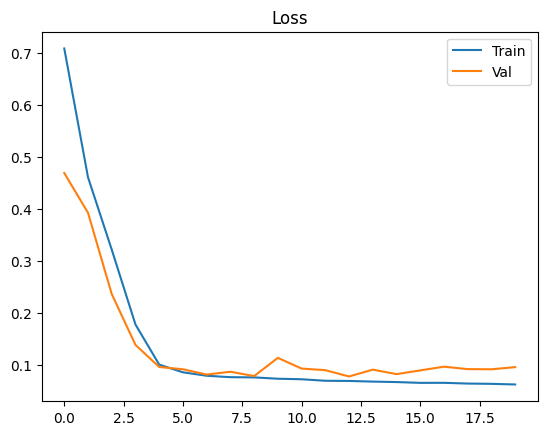

In [9]:
# Model Parameters
num_jet_feats = 6
num_trk_feats = 6
embed_dim = 32
num_heads = 8
out_classes = 1

model = AttnModel(num_jet_feats,num_trk_feats,embed_dim,num_heads,out_classes)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00005)

Epochs = 20

loss_fn = nn.BCELoss()

combined_history = train(model, X_train, y_train, X_val, y_val,epochs=Epochs)

plt.plot(combined_history[:,0], label="Train")
plt.plot(combined_history[:,1], label="Val")
plt.title('Loss')
plt.legend()
plt.show()

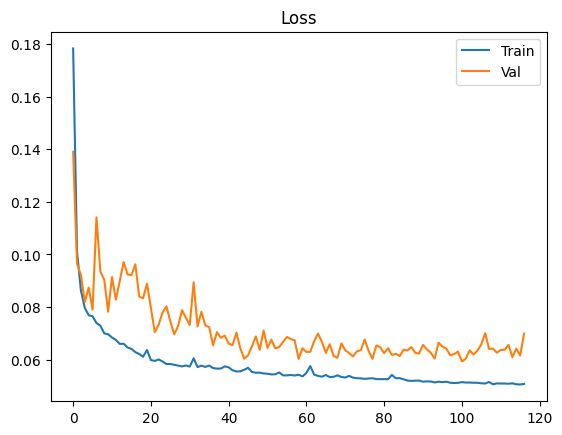

In [28]:
#combined_history2 = train(model, X_train, y_train, X_val, y_val,epochs=40)
#combined_history = np.vstack((combined_history, combined_history2))

plt.plot(combined_history[3:,0], label="Train")
plt.plot(combined_history[3:,1], label="Val")
plt.title('Loss')
plt.legend()
plt.show()

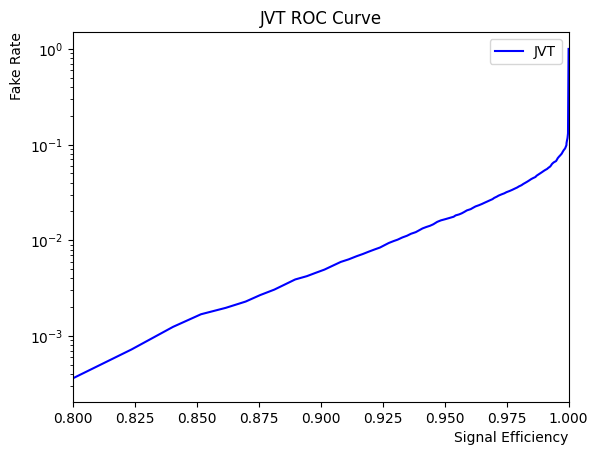

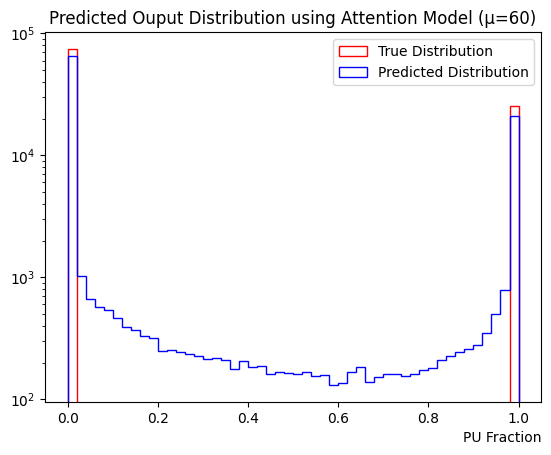

Test Binary Accuracy:	 0.9752403990324063

Train Loss:	 0.0507540508590396
Val Loss:	 0.06989449408393375
Test Loss:	 0.06130114113368165


In [26]:
def roc(y_true, y_pred):
    sig = (y_true==1)
    bkg = ~sig
    
    sig_eff = []
    fake_rate = []
    
    thresholds = np.linspace(0,0.99,100)
    
    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))
        fake_rate.append(((y_pred[bkg] > threshold).sum()  / y_true[bkg].shape[0]))
        
    return np.array(sig_eff), np.array(fake_rate), thresholds

model.eval()
cumulative_loss_test = 0
predicted_labels = []
true_labels = []

num_test = len(X_test)
for i in range(num_test):
    output = model(X_test[i][0].to(device), X_test[i][1].to(device), X_test[i][2].to(device))
    
    loss=loss_fn(output, y_test[i].to(device))
    cumulative_loss_test+=loss.detach().cpu().numpy().mean()
        
    for j in range(output.shape[0]): 
        predicted_labels.append(float(output[j][0].detach().cpu().numpy()))
        true_labels.append(float(y_test[i][j][0].detach().numpy()))
    
cumulative_loss_test = cumulative_loss_test / num_test

x1,y1,th1 = roc(np.array(ak.ravel(y_test)),np.array(ak.ravel(predicted_labels)))

plt.title("JVT ROC Curve")
plt.plot(x1,y1,color='b',label='JVT')

plt.ylabel('Fake Rate',loc='top')
plt.xlabel('Signal Efficiency',loc='right')
plt.yscale('log')
plt.legend()
plt.xlim([0.8, 1])
plt.show()

plt.hist(true_labels,histtype='step',color='r',label='True Distribution',bins=50,range=(0,1))
plt.hist(predicted_labels,histtype='step',color='b',label='Predicted Distribution',bins=50,range=(0,1))
plt.title("Predicted Ouput Distribution using Attention Model (\u03BC=60)")
plt.legend()
plt.yscale('log')
plt.xlabel('PU Fraction',loc='right')
plt.show()
print("Test Binary Accuracy:\t", accuracy_score(true_labels, (np.array(predicted_labels)>threshold)))
print()
print("Train Loss:\t", combined_history[-1][0])
print("Val Loss:\t", combined_history[-1][1])
print("Test Loss:\t", cumulative_loss_test)

In [27]:
file_names = ["AttnJVT_wtracks_Results.np"]

results1 = np.concatenate((x1[np.newaxis],y1[np.newaxis],th1[np.newaxis]),axis=0)

results = [results1]

for i, file in enumerate(file_names):
    with open(file, 'wb') as f:
        np.save(f, results[i])